https://github.com/qubvel/segmentation_models.pytorch::

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os, cv2, glob, shutil
import numpy as np
import pandas as pd
import random, tqdm
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
!pip install --upgrade opencv-python

     |████████████████████████████████| 60.5 MB 1.1 MB/s 
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.1.2.30
    Uninstalling opencv-python-4.1.2.30:
      Successfully uninstalled opencv-python-4.1.2.30
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


In [3]:
!pip install -U albumentations
import albumentations as album

     |████████████████████████████████| 102 kB 7.0 MB/s 
     |████████████████████████████████| 47.8 MB 1.8 MB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


In [4]:
!pip install -q -U segmentation-models-pytorch albumentations > /dev/null
import segmentation_models_pytorch as smp

In [5]:
# 경로 설정
# 20171630
#DATA_DIR = '/content/drive/MyDrive/College/캡스톤디자인 (Development of histologic and pathological photographic intellectualization analysis system)/test'
# gwj0421
DATA_DIR = '/content/drive/Shareddrives/Wongs/캡스톤디자인 (Development of histologic and pathological photographic intellectualization analysis system)/test'
dataset_path = os.path.join(DATA_DIR,'dataset')

x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'val_labels')

x_test_dir = os.path.join(DATA_DIR, 'test')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

In [6]:
def permutation_train_test_split(data,label , test_size=0.2, shuffle=True, random_state=1004):
    data_len=len(data)
    print(f'전체 데이터수 : {data_len}')
    test_num=int(data_len*test_size)
    valid_num=test_num
    train_num=data_len-test_num-valid_num
    
    if shuffle:
        np.random.seed(100)
        shuffled=np.random.permutation(data_len)
        data=data[shuffled]
        label=label[shuffled]
        x_train=data[:train_num]
        y_train=label[:train_num]
        x_valid=data[train_num:train_num+valid_num]
        y_valid=label[train_num:train_num+valid_num]
        x_test=data[-test_num:]
        y_test=label[-test_num:]
    else:
        x_train=data[:train_num]
        y_train=label[:train_num]
        x_valid=data[train_num:train_num+valid_num]
        y_valid=label[train_num:train_num+valid_num]
        x_test=data[-test_num:]
        y_test=label[-test_num:]

    return x_train, y_train, x_valid, y_valid, x_test, y_test

# Train, Validation, Test 파일 나누기 (6:2:2)
X_path=np.array(glob.glob(os.path.join(dataset_path,'Image_all_crop/*.jpg')))
Y_path=np.array(glob.glob(os.path.join(dataset_path,'Image_all_label/*.jpg')))
x_train, y_train, x_valid, y_valid, x_test, y_test=permutation_train_test_split(X_path,Y_path,test_size=0.2,shuffle=True,random_state=1004)
print(len(x_train),len(y_train),len(x_valid),len(y_valid),len(x_test),len(y_test))

전체 데이터수 : 512
308 308 102 102 102 102


In [7]:
# split한 데이터 각 경로에 저장
# for i in x_train:
#     shutil.copy2(i,x_train_dir)
# for i in y_train:
#     shutil.copy2(i,y_train_dir)
# for i in x_valid:
#     shutil.copy2(i,x_valid_dir)
# for i in y_valid:
#     shutil.copy2(i,y_valid_dir)
# for i in x_test:
#     shutil.copy2(i,x_test_dir)
# for i in y_test:
#     shutil.copy2(i,y_test_dir)

In [8]:
class_dict = pd.read_csv(os.path.join(DATA_DIR,'label_class_dict.csv'))
# 각 class 이름
class_names = class_dict['name'].tolist()
# 각 class에 해당하는 rgb값
class_rgb_values = class_dict[['r','g','b']].values.tolist()

print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Class Names:  ['background', 'cell']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [9]:
select_classes = ['background', 'cell']


select_class_indices = [class_names.index(cls.lower()) for cls in select_classes]
select_class_rgb_values =  np.array(class_rgb_values)[select_class_indices]

print('Class Names: ', class_names)
print('Class RGB values: ', class_rgb_values)

Class Names:  ['background', 'cell']
Class RGB values:  [[0, 0, 0], [255, 255, 255]]


In [10]:
# data visualization
def visualize(**images):
    """
    Plot images in one row
    """
    n_images = len(images)
    plt.figure(figsize=(20,8))
    for idx, (name, image) in enumerate(images.items()):
        plt.subplot(1, n_images, idx + 1)
        plt.xticks([]); 
        plt.yticks([])
        # get title from the parameter names
        plt.title(name.replace('_',' ').title(), fontsize=20)
        plt.imshow(image)
    plt.show()

# Perform one hot encoding on label
def one_hot_encode(label, label_values):
    """
    Convert a segmentation image label array to one-hot format
    by replacing each pixel value with a vector of length num_classes
    # Arguments
        label: The 2D array segmentation image label
        label_values
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of num_classes
    """
    semantic_map = []
    for colour in label_values:
        equality = np.equal(label, colour)
        class_map = np.all(equality, axis = -1)
        semantic_map.append(class_map)
    semantic_map = np.stack(semantic_map, axis=-1)

    return semantic_map
    
# Perform reverse one-hot-encoding on labels / preds
def reverse_one_hot(image):
    """
    Transform a 2D array in one-hot format (depth is num_classes),
    to a 2D array with only 1 channel, where each pixel value is
    the classified class key.
    # Arguments
        image: The one-hot format image 
        
    # Returns
        A 2D array with the same width and hieght as the input, but
        with a depth size of 1, where each pixel value is the classified 
        class key.
    """
    x = np.argmax(image, axis = -1)
    return x

# Perform colour coding on the reverse-one-hot outputs
def colour_code_segmentation(image, label_values):
    """
    Given a 1-channel array of class keys, colour code the segmentation results.
    # Arguments
        image: single channel array where each value represents the class key.
        label_values

    # Returns
        Colour coded image for segmentation visualization
    """
    colour_codes = np.array(label_values)
    x = colour_codes[image.astype(int)]

    return x

In [11]:
class CellsDataset(torch.utils.data.Dataset):

    """Massachusetts Buildings Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_rgb_values (list): RGB values of select classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            class_rgb_values=None, 
            augmentation=None, 
            preprocessing=None,
    ):
        
        self.image_paths = [os.path.join(images_dir, image_id) for image_id in sorted(os.listdir(images_dir))]
        self.mask_paths = [os.path.join(masks_dir, image_id) for image_id in sorted(os.listdir(masks_dir))]

        self.class_rgb_values = class_rgb_values
        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # 이미지 읽기
        image = cv2.cvtColor(cv2.imread(self.image_paths[i]), cv2.COLOR_BGR2RGB)
        mask = cv2.cvtColor(cv2.imread(self.mask_paths[i]), cv2.COLOR_BGR2RGB)
        
        # one-hot-encode the mask
        mask = one_hot_encode(mask, self.class_rgb_values).astype('float')
        
        # 데이터 증대
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        
        # 데이터 전처리
        if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
            
        return image, mask
        
    def __len__(self):
        # return length of 
        return len(self.image_paths)

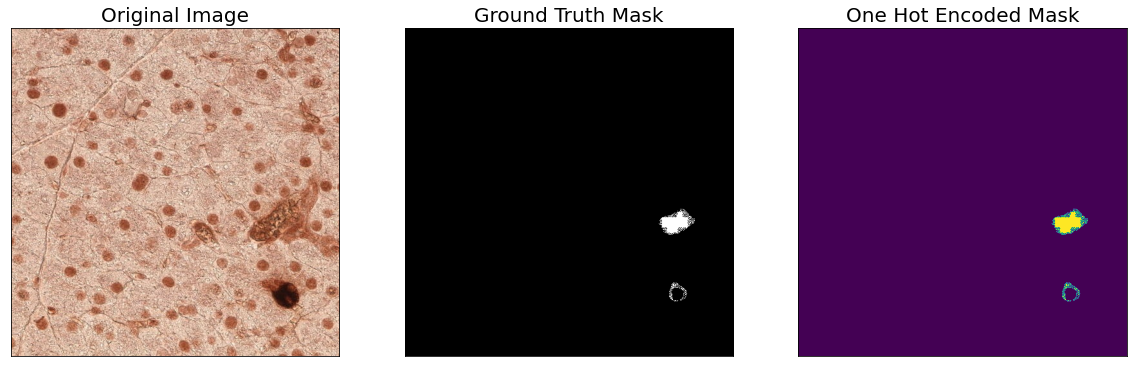

In [12]:
dataset = CellsDataset(x_train_dir, y_train_dir, class_rgb_values=select_class_rgb_values)
random_idx = random.randint(0, len(dataset)-1)
image, mask = dataset[2]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [13]:
def get_training_augmentation():
    train_transform = [    
        album.RandomCrop(height=256, width=256, always_apply=True),
        album.OneOf(
            [
                album.HorizontalFlip(p=1),
                album.VerticalFlip(p=1),
                album.RandomRotate90(p=1),
            ],
            p=0.75,
        ),
    ]
    return album.Compose(train_transform)


def get_validation_augmentation():   
    # Add sufficient padding to ensure image is divisible by 32
    test_transform = [
        #album.PadIfNeeded(min_height=1536, min_width=1536, always_apply=True, border_mode=0),
    ]
    return album.Compose(test_transform)


def to_tensor(x, **kwargs):
    return x.transpose(2, 0, 1).astype('float32')


def get_preprocessing(preprocessing_fn=None):
    """Construct preprocessing transform    
    Args:
        preprocessing_fn (callable): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    """   
    _transform = []
    if preprocessing_fn:
        _transform.append(album.Lambda(image=preprocessing_fn))
    _transform.append(album.Lambda(image=to_tensor, mask=to_tensor))
        
    return album.Compose(_transform)

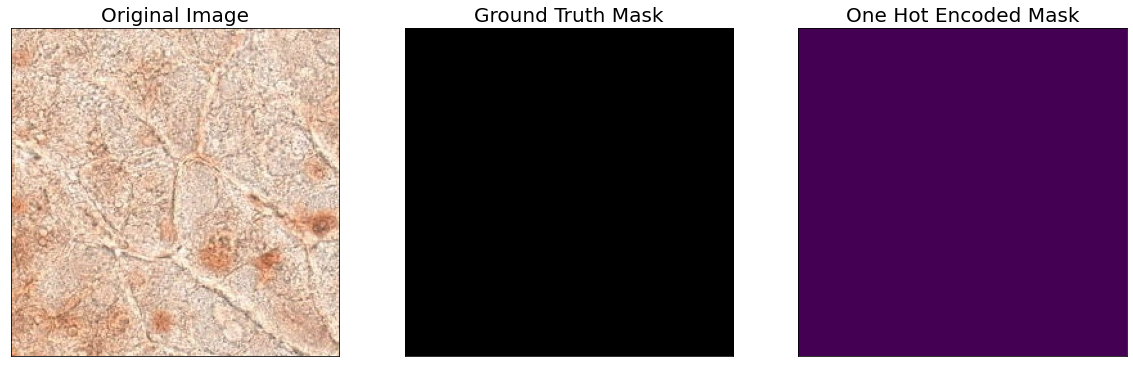

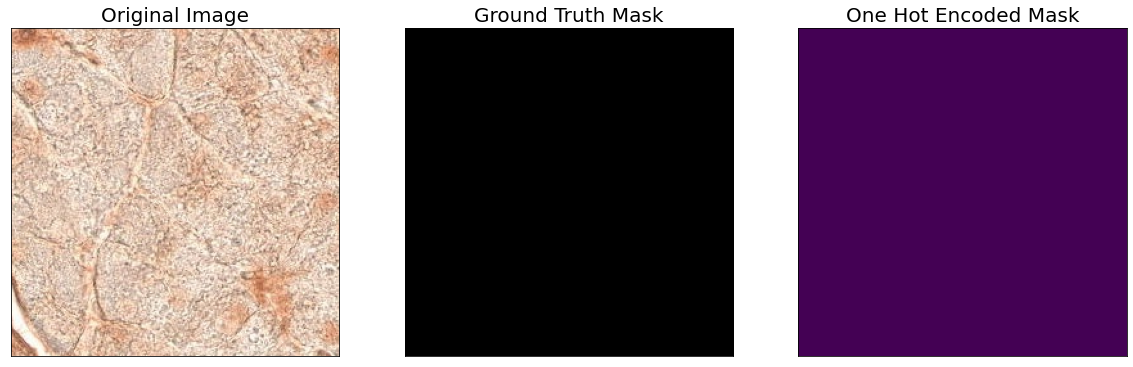

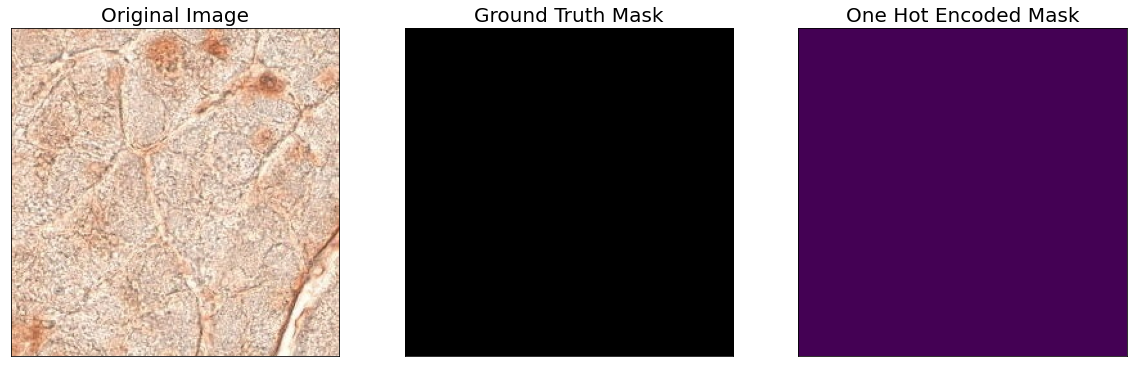

In [14]:
augmented_dataset = CellsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

random_idx = random.randint(0, len(augmented_dataset)-1)

# Different augmentations on a random image/mask pair (256*256 crop)
for i in range(3):
    image, mask = augmented_dataset[random_idx]
    visualize(
        original_image = image,
        ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
        one_hot_encoded_mask = reverse_one_hot(mask)
    )

In [30]:
ENCODER = 'resnet50'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = class_names
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
MODEL_NAME='UnetPlusPlus'
# create segmentation model with pretrained encoder
if MODEL_NAME=='UNet':
    model = smp.Unet(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=len(CLASSES), 
        activation=ACTIVATION,
    )
elif MODEL_NAME=='UnetPlusPlus':
    model = smp.UnetPlusPlus(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=len(CLASSES), 
        activation=ACTIVATION,
    )
elif MODEL_NAME=='MAnet':
    model = smp.MAnet(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=len(CLASSES), 
        activation=ACTIVATION,
    )
elif MODEL_NAME=='Linknet':
    model = smp.Linknet(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=len(CLASSES), 
        activation=ACTIVATION,
    )
elif MODEL_NAME=='FPN':
    model = smp.FPN(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=len(CLASSES), 
        activation=ACTIVATION,
    )
elif MODEL_NAME=='PSPNet':
    model = smp.PSPNet(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=len(CLASSES), 
        activation=ACTIVATION,
    )
elif MODEL_NAME=='PAN':
    model = smp.PAN(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=len(CLASSES), 
        activation=ACTIVATION,
    )
elif MODEL_NAME=='DeepLabV3':
    model = smp.DeepLabV3(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=len(CLASSES), 
        activation=ACTIVATION,
    )
elif MODEL_NAME=='DeepLabV3Plus':
    model = smp.DeepLabV3Plus(
        encoder_name=ENCODER, 
        encoder_weights=ENCODER_WEIGHTS, 
        classes=len(CLASSES), 
        activation=ACTIVATION,
    )
preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

In [31]:
# train dataset 설정
train_dataset = CellsDataset(
    x_train_dir, y_train_dir, 
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# validation dataset 설정
valid_dataset = CellsDataset(
    x_valid_dir, y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

# Get train and val data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=12)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=4)

In [32]:
# Set flag to train the model or not. If set to 'False', only prediction is performed (using an older model checkpoint)
TRAINING = True

# Set num of epochs
EPOCHS = 10

# Set device: `cuda` or `cpu`
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 손실함수 DiceLoss 사용
loss = smp.utils.losses.DiceLoss()

# define metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
]

# 옵티마이저 Adam 사용
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

# define learning rate scheduler (not used in this NB)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer, T_0=1, T_mult=2, eta_min=5e-5,
)

# # load best saved model checkpoint from previous commit (if present)
# if os.path.exists('../input/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth'):
#     model = torch.load('../input/unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth', map_location=DEVICE)

In [33]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

In [34]:
%%time
# 학습
os.makedirs(os.path.join(DATA_DIR,'ckpt'), exist_ok=True)
if TRAINING:

    best_iou_score = 0.0
    train_logs_list, valid_logs_list = [], []

    for i in range(0, EPOCHS):

        # Perform training & validation
        print('\nEpoch: {}'.format(i))
        train_logs = train_epoch.run(train_loader)
        valid_logs = valid_epoch.run(valid_loader)
        train_logs_list.append(train_logs)
        valid_logs_list.append(valid_logs)

        # Save model if a better val IoU score is obtained
        if best_iou_score < valid_logs['iou_score']:
            best_iou_score = valid_logs['iou_score']
            torch.save(model,os.path.join(DATA_DIR,'ckpt/best_model_{}.pth'.format(MODEL_NAME)))
            print('Model saved!')


Epoch: 0
valid: 100%|██████████| 102/102 [00:12<00:00,  8.34it/s, dice_loss - 0.4175, iou_score - 0.6165]
Model saved!

Epoch: 1
valid: 100%|██████████| 102/102 [00:11<00:00,  8.56it/s, dice_loss - 0.3665, iou_score - 0.6866]
Model saved!

Epoch: 2
valid: 100%|██████████| 102/102 [00:11<00:00,  8.56it/s, dice_loss - 0.3224, iou_score - 0.7601]
Model saved!

Epoch: 3
valid: 100%|██████████| 102/102 [00:11<00:00,  8.54it/s, dice_loss - 0.2901, iou_score - 0.8067]
Model saved!

Epoch: 4
valid: 100%|██████████| 102/102 [00:11<00:00,  8.56it/s, dice_loss - 0.2753, iou_score - 0.8341]
Model saved!

Epoch: 5
valid: 100%|██████████| 102/102 [00:11<00:00,  8.57it/s, dice_loss - 0.2628, iou_score - 0.8492]
Model saved!

Epoch: 6
valid: 100%|██████████| 102/102 [00:11<00:00,  8.59it/s, dice_loss - 0.2422, iou_score - 0.8501]
Model saved!

Epoch: 7
valid: 100%|██████████| 102/102 [00:12<00:00,  8.36it/s, dice_loss - 0.2332, iou_score - 0.8563]
Model saved!

Epoch: 8
valid: 100%|██████████| 102/10

In [35]:
# load best saved model checkpoint from the current run
if os.path.exists(os.path.join(DATA_DIR,'ckpt/best_model_{}.pth'.format(MODEL_NAME))):
    best_model = torch.load(os.path.join(DATA_DIR,'ckpt/best_model_{}.pth'.format(MODEL_NAME)), map_location=DEVICE)
    print('Loaded UNet model from this run.')

# load best saved model checkpoint from previous commit (if present)
# elif os.path.exists('../input//unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth'):
#     best_model = torch.load('../input//unet-with-pretrained-resnet50-encoder-pytorch/best_model.pth', map_location=DEVICE)
#     print('Loaded UNet model from a previous commit.')

Loaded UNet model from this run.


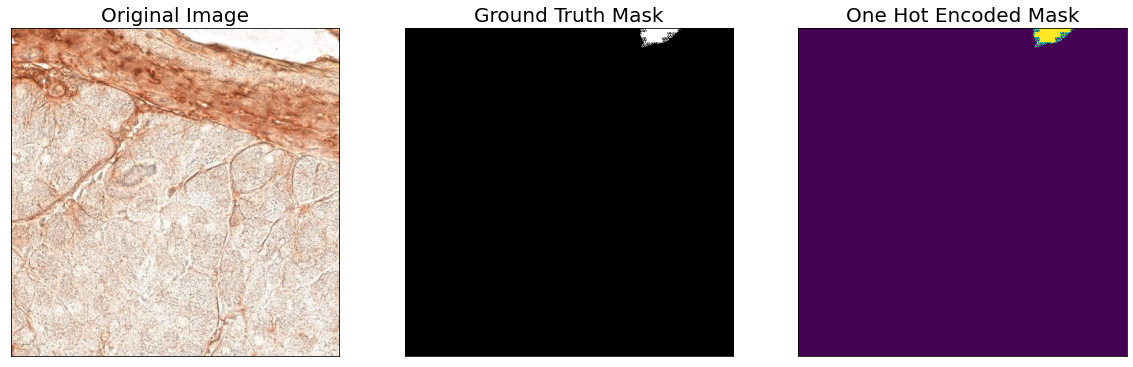

In [36]:
# create test dataloader (with preprocessing operation: to_tensor(...))
test_dataset = CellsDataset(
    x_test_dir, 
    y_test_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    class_rgb_values=select_class_rgb_values,
)

test_dataloader = DataLoader(test_dataset)

# test dataset for visualization (without preprocessing transformations)
test_dataset_vis = CellsDataset(
    x_test_dir, y_test_dir, 
    augmentation=get_validation_augmentation(),
    class_rgb_values=select_class_rgb_values,
)

# get a random test image/mask index
random_idx = random.randint(0, len(test_dataset_vis)-1)
image, mask = test_dataset_vis[random_idx]

visualize(
    original_image = image,
    ground_truth_mask = colour_code_segmentation(reverse_one_hot(mask), select_class_rgb_values),
    one_hot_encoded_mask = reverse_one_hot(mask)
)

In [37]:
# Center crop padded image / mask to original image dims
def crop_image(image, target_image_dims=[512,512,3]):
   
    target_size = target_image_dims[0]
    image_size = len(image)
    padding = (image_size - target_size) // 2

    return image[
        padding:image_size - padding,
        padding:image_size - padding,
        :,
    ]

In [38]:
sample_preds_folder = os.path.join(DATA_DIR,'sample_predictions')
sample_preds_path= os.path.join(sample_preds_folder,'{}'.format(MODEL_NAME))
sample_preds_image_path=os.path.join(sample_preds_path,'images')

os.makedirs(sample_preds_folder,exist_ok=True)
os.makedirs(sample_preds_path,exist_ok=True)
os.makedirs(sample_preds_image_path,exist_ok=True)

In [39]:
for idx in tqdm.tqdm(range(len(test_dataset)),desc='{}'.format(MODEL_NAME),mininterval=0.01):

    image, gt_mask = test_dataset[idx]
    image_vis = crop_image(test_dataset_vis[idx][0].astype('uint8'))
    x_tensor = torch.from_numpy(image).to(DEVICE).unsqueeze(0)
    # Predict test image
    pred_mask = best_model(x_tensor)
    pred_mask = pred_mask.detach().squeeze().cpu().numpy()
    # Convert pred_mask from `CHW` format to `HWC` format
    pred_mask = np.transpose(pred_mask,(1,2,0))
    # Get prediction channel corresponding to building
    pred_building_heatmap = pred_mask[:,:,select_classes.index('cell')]
    pred_mask = crop_image(colour_code_segmentation(reverse_one_hot(pred_mask), select_class_rgb_values))
    # Convert gt_mask from `CHW` format to `HWC` format
    
    gt_mask = np.transpose(gt_mask,(1,2,0))
    gt_mask = crop_image(colour_code_segmentation(reverse_one_hot(gt_mask), select_class_rgb_values))
    cv2.imwrite(os.path.join(sample_preds_image_path, f"sample_pred_{idx}.png"), np.hstack([image_vis, gt_mask, pred_mask])[:,:,::-1])
    
    # visualize(
    #     original_image = image_vis,
    #     ground_truth_mask = gt_mask,
    #     predicted_mask = pred_mask,
    #     predicted_building_heatmap = pred_building_heatmap
    # )

UnetPlusPlus: 100%|██████████| 102/102 [00:25<00:00,  3.95it/s]


In [40]:
test_epoch = smp.utils.train.ValidEpoch(
    model,
    loss=loss, 
    metrics=metrics, 
    device=DEVICE,
    verbose=True,
)

valid_logs = test_epoch.run(test_dataloader)
print("Evaluation on Test Data: ")
print(f"Mean IoU Score: {valid_logs['iou_score']:.4f}")
print(f"Mean Dice Loss: {valid_logs['dice_loss']:.4f}")

valid: 100%|██████████| 102/102 [00:15<00:00,  6.74it/s, dice_loss - 0.203, iou_score - 0.8578]
Evaluation on Test Data: 
Mean IoU Score: 0.8578
Mean Dice Loss: 0.2030


In [41]:
train_logs_df = pd.DataFrame(train_logs_list)
valid_logs_df = pd.DataFrame(valid_logs_list)
train_logs_df.T

,0,1,2,3,4,5,6,7,8,9
dice_loss,0.433468,0.367655,0.324287,0.289145,0.269193,0.253719,0.239311,0.229424,0.214264,0.202305
iou_score,0.479609,0.629846,0.716160,0.825506,0.863416,0.861100,0.865862,0.862070,0.870548,0.877967


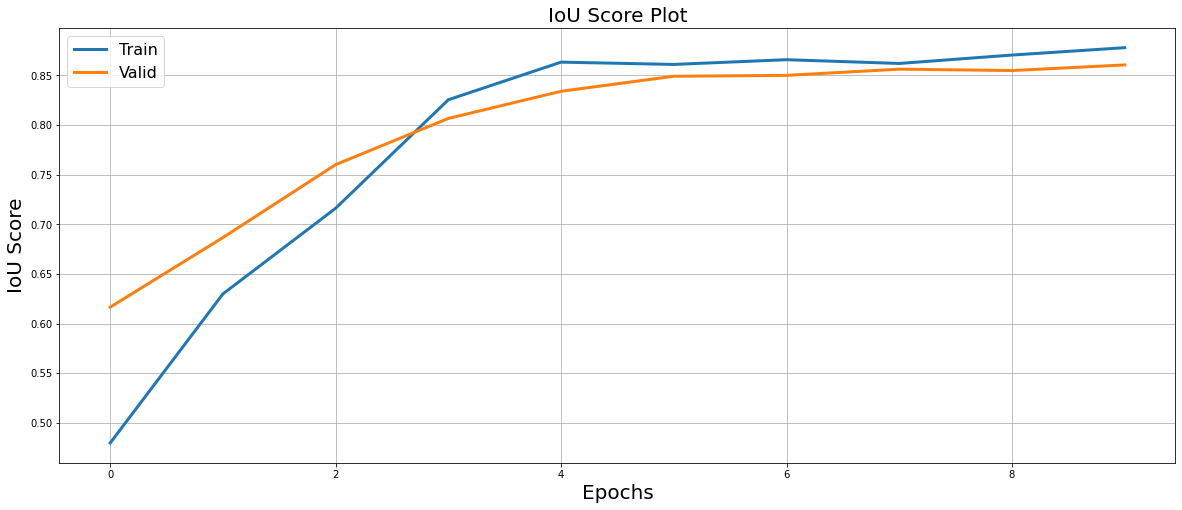

In [42]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.iou_score.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.iou_score.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('IoU Score', fontsize=20)
plt.title('IoU Score Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig(os.path.join(sample_preds_path,'iou_score_plot.png'))
plt.show()

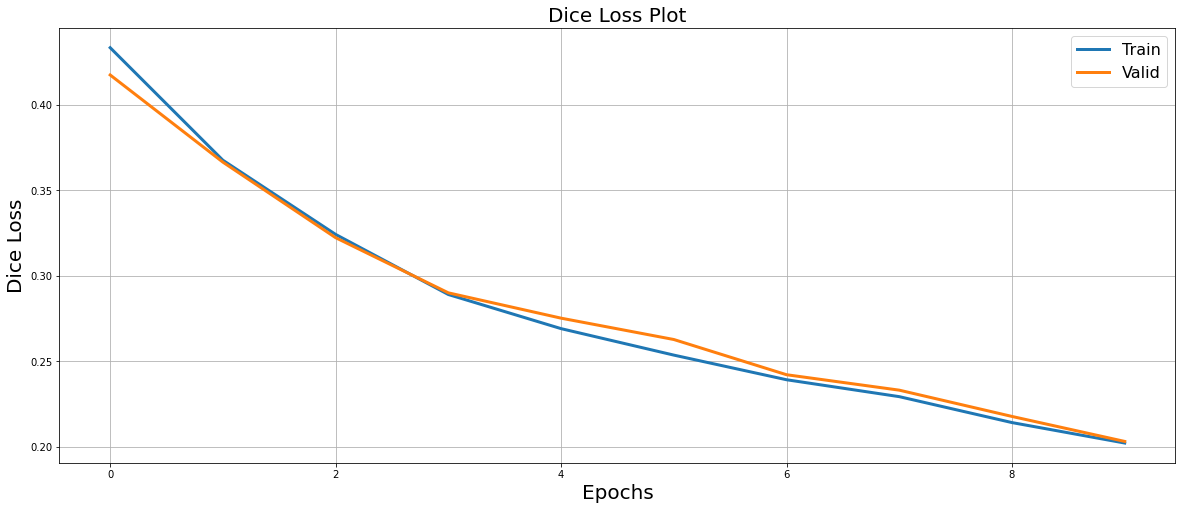

In [43]:
plt.figure(figsize=(20,8))
plt.plot(train_logs_df.index.tolist(), train_logs_df.dice_loss.tolist(), lw=3, label = 'Train')
plt.plot(valid_logs_df.index.tolist(), valid_logs_df.dice_loss.tolist(), lw=3, label = 'Valid')
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Dice Loss', fontsize=20)
plt.title('Dice Loss Plot', fontsize=20)
plt.legend(loc='best', fontsize=16)
plt.grid()
plt.savefig(os.path.join(sample_preds_path,'dice_loss_plot.png'))
plt.show()

In [44]:
print('{} done'.format(MODEL_NAME))

UnetPlusPlus done
